In [34]:
import os
import numpy as np
import matplotlib.backends.backend_pdf as backend_pdf
import matplotlib.pyplot as plt
import arviz
import seaborn as sns
from ete3 import Tree

from plotting import *

# Diagnostics notebook

In [6]:
#  this will be read in as variable from the script.. 
MCMC_iter = 10000 #10000 in the paper 
burnin = 2000 # 2000 in the paper 
nthin = 1 # see from script/running conditions, not used for plotting
folder_runs = '_chazot/runs_rb=5_v6/'#_butterfly-analysis/runs/'
nxd=40
treefile = 'data/chazot_full_tree.nw'
pars_name = ['kalpha', 'gtheta']
rep_path = len(pars_name)+1
chains = os.listdir(folder_runs) # use all chains in data seed folder 
chains = [c for c in chains if c[0] not in ['_', '.']] # remove files starting with underscore
print(chains)
temp_name = ['' for i in range(len(chains))]


['warm-elevator-150', 'spring-firefly-151', 'dandy-moon-152']


In [7]:
# get levelorder tree 
phylogeny = Tree(treefile, format=1)
leafidx = []
inneridx = []
i = 0
for node in phylogeny.traverse('levelorder'):
    if node.is_leaf():
        print(node.name)
        leafidx.append(i)
    else:
        inneridx.append(i)
    i+=1
print(leafidx)
print(inneridx)
nnodes = len(leafidx) + len(inneridx)   

eugenia
marcus
polyphemus
anaxibia
cypris
rhetenor
cisseis
hecuba
niepelti
theseus
hercules
granadensis
deidamia
amathonte
amphitryon
telemachus
achilles
helenor
epistrophus
iphitus
godartii
menelaus
zephyritis
lympharis
sulkowskyi
aega
portis
rhodopteron
absoloni
aurora
[3, 4, 9, 11, 17, 18, 19, 20, 27, 28, 29, 31, 33, 35, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 57, 58]
[0, 1, 2, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 30, 32, 34, 36, 37, 38, 48, 49, 50, 56]


In [8]:
print(phylogeny)


      /-eugenia
   /-|
  |   \-marcus
  |
  |         /-anaxibia
  |      /-|
  |     |  |   /-cypris
  |     |   \-|
  |     |      \-rhetenor
  |   /-|
--|  |  |      /-cisseis
  |  |  |   /-|
  |  |  |  |   \-hecuba
  |  |  |  |
  |  |   \-|      /-niepelti
  |  |     |   /-|
  |  |     |  |   \-theseus
  |  |      \-|
  |  |        |   /-hercules
   \-|         \-|
     |           |   /-amphitryon
     |            \-|
     |               \-telemachus
     |
     |   /-polyphemus
     |  |
     |  |         /-granadensis
     |  |      /-|
     |  |     |  |   /-achilles
     |  |     |   \-|
      \-|   /-|      \-helenor
        |  |  |
        |  |  |   /-deidamia
        |  |   \-|
        |  |     |   /-epistrophus
        |  |      \-|
        |  |         \-iphitus
         \-|
           |      /-amathonte
           |   /-|
           |  |  |   /-godartii
           |  |   \-|
           |  |      \-menelaus
           |  |
            \-|      /-zephyritis
            

In [9]:
# read in data and MCMC chains
raw_trees = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"tree_nodes.csv", delimiter = ",") for i in range(len(chains))]
tree_counters = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"tree_counter.csv", delimiter = ",").astype(int) for i in range(len(chains))]
flat_trees_raw = [raw_trees[i].reshape(len(tree_counters[i]),nnodes,nxd) for i in range(len(raw_trees))]
#flat_true_tree = np.genfromtxt(folder_simdata+"flat_true_tree.csv", delimiter = ",")
super_root = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"inference_root_start.csv", delimiter = ",") for i in range(len(chains))]
_super_root = [np.concatenate((super_root[i], super_root[i][0:2])) for i in range(len(chains))]
_super_root = np.unique(np.array(_super_root), axis=0)


# In[12]:
flat_trees = np.array([np.repeat(flat_trees_raw[i], tree_counters[i], axis=0)[burnin*rep_path:(MCMC_iter//nthin)*rep_path] for i in range(len(flat_trees_raw))])
flat_trees.shape

(3, 24000, 59, 40)

In [10]:
# create output folder
outputfolder = folder_runs
path = outputfolder+'_*'+'-'.join(chains)
if not os.path.isdir(path): 
    os.mkdir(path)
    os.mkdir(path+'/stats')

## Gelman-Rubin convergence diagnostics

In [11]:

# get rhat and ESS for all nodes and dimensions
rhats = []
esss = []
for idx in range(flat_trees.shape[2]):  # calculate for all nodes 
    innernodes = flat_trees[:,:,idx, :]
    keys = list(range(innernodes.shape[2]))
    MCMCres = arviz.convert_to_dataset({k:innernodes[:,:,i] for i,k in enumerate(keys)})
    rhats.append(arviz.rhat(MCMCres).to_array().to_numpy())
    esss.append(arviz.ess(MCMCres).to_array().to_numpy())

# save rhat for plotting
np.savetxt(path+'/stats/'+"rhats_paths.csv",np.array(rhats), delimiter=",")

## Plot traces and diagnostics paths

In [12]:
plot_traces_tree(flat_trees, inneridx, esss, rhats,None, outpath = path + f'/trace-innernodes_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

0
1
2
5
6
7
8
10
12
13
14
15
16
21
22
23
24
25
26
30


/Users/lkn315/Library/CloudStorage/OneDrive-UniversityofCopenhagen/stochastic_phylogenetic_models_of_shape/plotting.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(25,15), sharex=True)


32
34
36
37
38
48
49
50
56


<Figure size 640x480 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

In [13]:
summary_rhat(rhats, inneridx, outpath = path + f'/summary_rhat_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

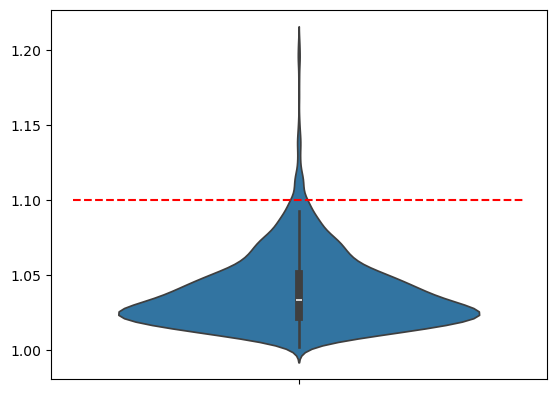

In [14]:
sns.violinplot(np.array(rhats).flatten())
plt.hlines(y=1.1, xmin=-0.5, xmax=0.5, color='red', linestyle='--')
plt.savefig(path + f'/summary_rhat_allnodes_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

## Plot posterior path

In [ ]:
def plot_posterior_(flat_trees, inneridx, outpath, flat_true_tree=False, sample_n=50, nxd=40):
    # plot summary of Rhat values 
    n_nodes = len(inneridx)
    # Determine the grid size
    grid_size = int(np.ceil(np.sqrt(n_nodes)))
    # Create subplots
    fig, axes = plt.subplots(6, 5, figsize=(20, 30), sharex=True, sharey=True)
    #fig.suptitle(f'Samples from posterior (every {sample_n}) for all innernodes', size=20)
    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Create a scatter plot for each k
    for i in range(n_nodes):
        idx = inneridx[i]
        innernodes = flat_trees[:,:,idx,:].reshape(-1, nxd)[::sample_n,:]
        inode = innernodes #np.append(innernodes, innernodes[:,0:2],1)
        for j in range(inode.shape[0]):
            axes[i].plot(inode[j,::2], inode[j,1::2], '--.', color='steelblue', alpha=0.3)
        if flat_true_tree is not False:
            true_innernode = flat_true_tree[idx,:]
            tinode = np.concatenate((true_innernode, true_innernode[0:2]))  
            axes[i].plot(tinode[::2], tinode[1::2], '--.', color='black', label='True shape')
        axes[i].set_title(f'Node {idx}', size=20);

    # Hide any unused subplots
    for j in range(n_nodes, 6 * 5):
        fig.delaxes(axes[j])

   # plt.tight_layout()
    plt.savefig(outpath, bbox_inches='tight') #
    #fig.subplots_adjust(top=0.95)
    #plt.show()
    plt.close()
    gc.collect()


In [35]:
plot_posterior(flat_trees, inneridx, outpath = path + f'/posterior_samples_burnin={burnin}_MCMCiter={MCMC_iter}.png', flat_true_tree=False, sample_n=50, nxd=60)

## Plot parameters 

In [ ]:
par = pars_name[0]
o = [np.genfromtxt(folder_runs + chains[i]+'/'+par+"s.csv", delimiter = ",")[:MCMC_iter] for i in range(3)]
o[1].shape

In [ ]:
raw_pars = np.array([[np.genfromtxt(folder_runs + chains[i]+'/'+par+"s.csv", delimiter = ",")[:MCMC_iter] for i in range(len(chains))] for par in pars_name])
#raw_acceptpars = np.array([[np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+f"accept{par}.csv", delimiter = ",") for i in range(len(chains))] for par in pars_name])
#true_pars = [np.genfromtxt(folder_simdata +p+"_sim.csv", delimiter = ",") for p in pars_name]

In [ ]:
pars = raw_pars[:,:,burnin:MCMC_iter]
pars.shape
#acceptpars = raw_acceptpars[:,:,burnin:MCMC_iter]
#acceptance_rate = np.mean(acceptpars, axis=2) # add when neccesary information is stored 

In [ ]:
parsdict = dict(zip(pars_name, pars)) 
MCMC_result = parsdict 
parsres = arviz.convert_to_dataset(MCMC_result)
rhat = arviz.rhat(parsres)
mcse = arviz.mcse(parsres)
ess = arviz.ess(parsres)
arviz.summary(parsres, hdi_prob=0.95, round_to=4)





In [ ]:
# save rhat for plotting
rhats_par = np.array([rhat['kalpha'], rhat['gtheta']])
np.savetxt(path+'/stats/'+"rhats_pars.csv",np.array(rhats_par), delimiter=",")

keys = pars_name
print(keys)
print([pars[i].shape for i in range(len(pars))])

In [ ]:
keys = ['kalpha', 'gtheta']
colors = sns.color_palette('pastel', len(chains))
fig, axes = plt.subplots(nrows=len(keys), ncols=2, figsize=(20,10), sharex=False)
p = 0
for i, ax in zip(range(len(axes.flat)), axes.flat): 
        if i%2 == 0: 
            for j in range(pars[p].shape[0]): #loop over chains 
                ax.plot(pars[p][j,:], color=colors[j], alpha=0.5)
            #ax.hlines(y=true_vals[p], xmin=0, xmax=pars[p].shape[1], color='skyblue')
            if keys[p] == 'kalpha':
                ax.set_title(r'${\alpha}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            if keys[p] == 'gtheta':
                ax.set_title(r'${\sigma}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
        else:
            for j in range(pars[p].shape[0]):
                sns.kdeplot(pars[p][j,:], ax=ax)
                sns.rugplot(pars[p][j,:], ax=ax)
            if keys[p] == 'kalpha':
                ax.set_title(r'${\alpha}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            if keys[p] == 'gtheta':
                ax.set_title(r'${\sigma}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            p+=1
            #ax.legend(loc='upper right')
#fig.suptitle(f"Iter: {MCMC_iter}, Burnin: {burnin} \n", fontsize=15)
fig.tight_layout()
fig.savefig(path+f'/pars_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

